# Bayes Theorem

In probability theory and statistics, Bayes' theorem (alternatively Bayes' law or Bayes' rule), named after Reverend Thomas Bayes, describes the probability of an event, based on prior knowledge of conditions that might be related to the event. [1](https://plato.stanford.edu/archives/spr2019/entries/bayes-theorem/)

#### $$P(A|B) = \frac {P(B|A)P(A)}{P(B)}$$

I'm a visual learner. My favourite intuitive example of Bayes Theorem is this [using lego bricks](https://www.countbayesie.com/blog/2015/2/18/bayes-theorem-with-lego):

<img src="lego-probability-space.jpeg" width="400" height="400">

The image shows a 60 (6 * 10) lego unit area
 - 40 blue areas
 - 20 red areas
 - 6 intersecting yellow areas. 

We can work through the maths to determine the probabilities and conditional probabilities of each colour.

In [9]:
pBlue = 40/60
pRed = 20/60
pYellow = 6/60
pYellowRed = 4/20 # probabiity of Yellow given Red
pYellowBlue = 2 / 40 # probabiity of Yellow given Blue

print('Cond p(Yellow|Red) = {:.3f}'.format(pYellowRed))
print('Cond p(Yellow|Blue) = {:.3f}'.format(pYellowBlue))

Cond p(Yellow|Red) = 0.200
Cond p(Yellow|Blue) = 0.050


We now some baseline information for the probability and conditional probility of landing on each colour within the Legosphere. We can apply Bayes theorem to generate estimates for "if we land on a yellow brick, what is the probability its red underneath?"

$$P(A|B) = \frac {P(B|A)P(A)}{P(B)}$$

$$P(Red|Yellow) = \frac {P(Yellow|Red)P(Red)}{P(Yellow)}$$

In [ ]:
pRedYellow = pYellowRed*pRed/pYellow
print('Cond p(Red|Yellow) = {:.3f}'.format(pRedYellow))

## Example: Evaluating Insurance claim occurences using Bayesian Inference

Let's recall that Bayesian Inference follows:

 1. Evaluate prior assumptions and observational data. 
 1. Develop a probabilistic model of the data.
 1. Specify prior parameter values for the distributions of the probabilistic model.
 1. Apply Bayes’ theorem to derive the posterior parameter values. 
 
 
###  1. Evaluate prior assumptions and observational data. 
In this example we have sample data for insurance claims occuring by Poisson distributed process. The Poisson distribution is given by:

$$f(y_i|λ)=\frac{e^{−λ}λ^{y_i}}{y_i!}$$

Where lambda λ is the "rate" of events given by the total number of events (k) divided by the number of units (n) in the data (λ = k/n). In the Poisson disribution the expected value E(Y), mean E(X), and variance Var(Y) of Poisson distribution are the same; 

e.g., E(Y) = E(X) = Var(X) = λ. 

**note** that if the variance is greater than the mean, the data is said to be overdispersed. This is common in insurance claim data with lots of zeros and is better handled by the NegativeBinomial and [zero-inflated models](https://stats.idre.ucla.edu/r/dae/zip/) such as ZIP and ZINB.

In [11]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

Mean=1.91, Var=2.10


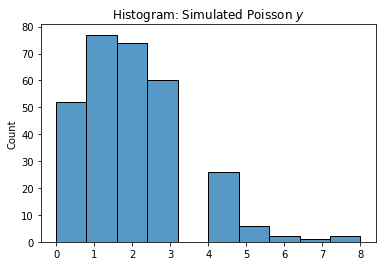

In [21]:
n = 300
lam_ = 2
y = np.random.poisson(lam=lam_,size=n)

print("Mean={:.2f}, Var={:.2f}".format(np.mean(y),np.var(y)))

sns.histplot(y,bins=10)
plt.title('Histogram: Simulated Poisson $y$');

The right-skew "heavy tail" in our observational data fits a gamma-poisson model. This is termed the gamma-poisson conjugate prior. We could also use a beta-poisson, or any distribution that resembles the data, but gamma-poisson is suitable as [Hyvönen & Tolonen 2019](https://vioshyvo.github.io/Bayesian_inference/conjugate-distributions.html): 
- poisson can take on any positive number to infinity(0,∞), whereas a beta or uniform is [0-100]. 
- gamma has a peak close to zero
- gamma tail goes to infinity.

The gamma-poisson prior is then:

$$λ∼Γ(a,b)$$

gamma density functions is:

$$f(λ)=\frac{b^a}{Γ(a)}λ^{a−1}e^{−bλ}$$

where a>0 is the shape parameter,and b>0 is the rate parameter, and 

$E(λ)=\frac{a}{b}$ and $Var(λ)=\frac{a}{b^2}$

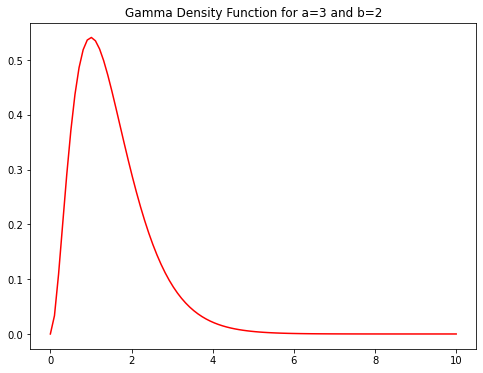

In [26]:
# Parameters of the prior gamma distribution.
a = 3 # shape
b = 2 # rate = 1/scale

x = np.linspace(start=0, stop=10, num=100)

plt.figure(figsize=(8, 6))
plt.plot(x, stats.gamma.pdf(x,a=a,scale=1/b), 'r-')
plt.title('Gamma Density Function for a={} and b={}'.format(a,b))

# Define the prior distribution.
prior = lambda x: stats.gamma.pdf(x, a=a, scale=1/b)

### references
- https://www.sciencedirect.com/science/article/abs/pii/S0740002005000249
- https://vioshyvo.github.io/Bayesian_inference/conjugate-distributions.html